已保存: plots\TSPZ158B0256_dark_StaticLeakage_Nonpara-off_400us_lab535\TSPZ158B0256_dark_StaticLeakage_Nonpara-off_400us_lab535.csv


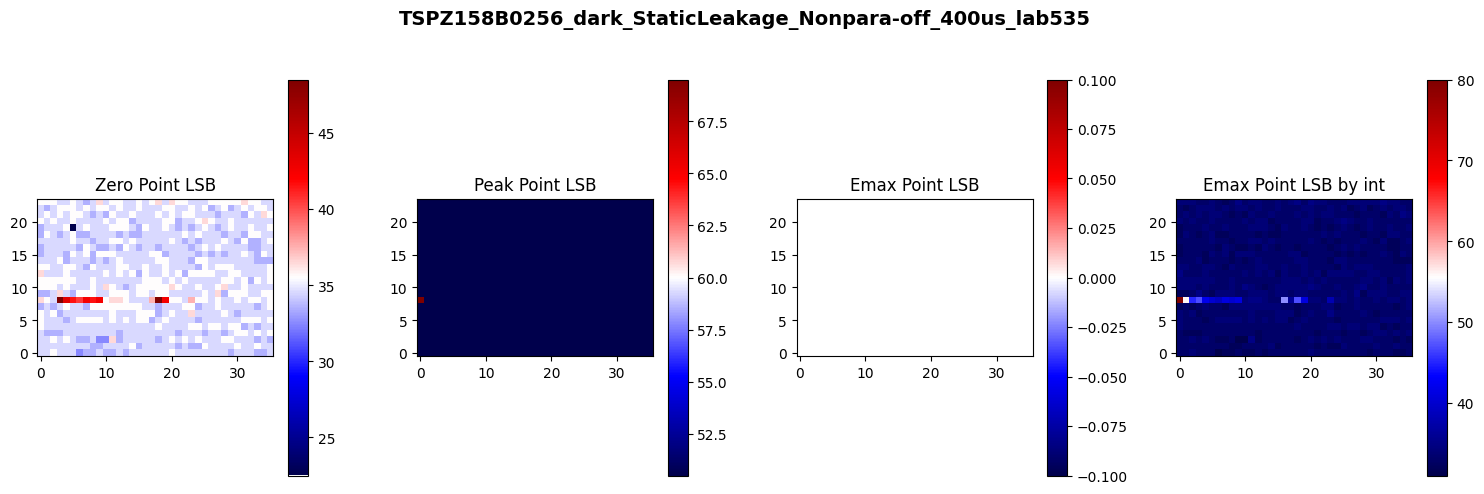

c:\Users\fei.li1\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_axes.py:7104: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\fei.li1\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_axes.py:7105: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

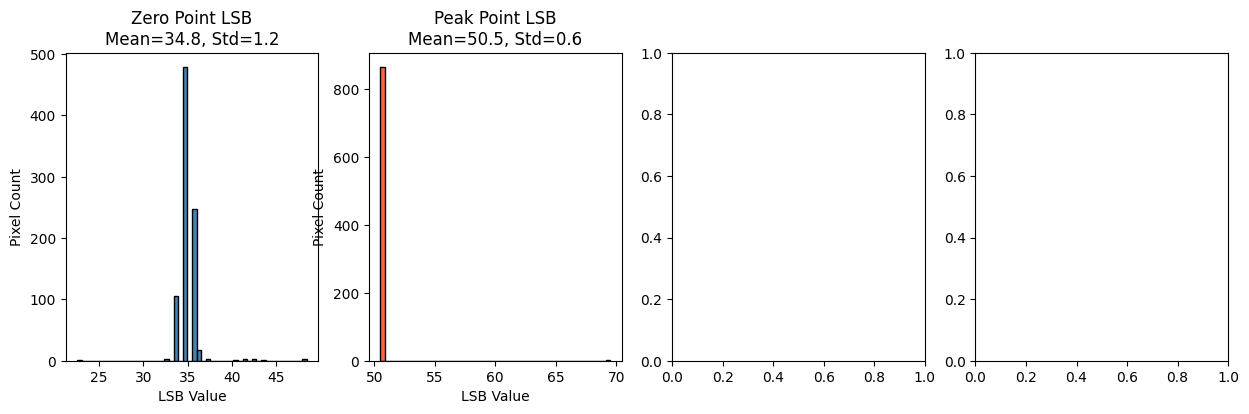

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import plotly.graph_objects as go
from pixel_utils import analyze_and_plot_pixel, make_clickable_map

# -----------------------
# 用户配置
# -----------------------
input_file = "output_raw/TSPZ158B0256_dark_StaticLeakage_Nonpara-off_400us_lab535.raw"
condition = Path(input_file).stem

# 主目录
condition_dir = Path("plots") / condition
pixels_dir = condition_dir / "pixels"
maps_dir = condition_dir / "maps"

# 一次性建好
pixels_dir.mkdir(parents=True, exist_ok=True)
maps_dir.mkdir(parents=True, exist_ok=True)
# -----------------------

# ---------读取 .raw 数据-------------- 
n_thresh = 256
nrow, ncol = 24, 36             #  晶体布局
data = np.fromfile(input_file, dtype=np.uint32)
npix = nrow * ncol  
data = data.reshape(-1, npix)   # (255, 864)
# -----------------------


# -------- 数据保存为csv -------------- 
df = pd.DataFrame({"Threshold": np.arange(n_thresh)})                       # 阈值列
col_names = [f"Pix_{pix//ncol}_{pix % ncol}" for pix in range(npix)]        # 像素列名
df_pixels = pd.DataFrame(data, columns=col_names)                           # 拼接成 DataFrame
df = pd.concat([df, df_pixels], axis=1)                                     # 合并
csv_path = condition_dir / f"{condition}.csv"                        # 保存为 CSV 
df.to_csv(csv_path, index=False)
print("已保存:", csv_path)
# -----------------------

# 初始化矩阵
map_zero = np.zeros((nrow, ncol))
map_peak = np.zeros((nrow, ncol))
map_emax = np.zeros((nrow, ncol))
map_emax_int = np.zeros((nrow, ncol))


# ---------逐像素绘图 TEST -------------- 

# for pix in range(npix):
#     row = pix // ncol
#     col = pix % ncol
#     integral = data[:, pix].astype(np.float64)
#     thr = np.arange(len(integral))  # 阈值序号 (0..255)
#     thr_mid = 0.5 * (thr[:-1] + thr[1:])  # 中点

#     LSB_zero, LSB_peak, LSB_emax, LSB_emax_int = analyze_and_plot_pixel(
#         integral, thr, thr_mid, row, col, condition,
#         outdir=pixels_dir, savefig=True
#     )

  

# ---------逐像素绘图-------------- 
for pix in range(npix):
    # 找像素在二维阵列中的坐标
    row = pix // ncol
    col = pix % ncol  

    integral = data[:, pix].astype(np.float64)        # 积分图
     
    diff = integral[:-1] - integral[1:]               # 微分图（简单前-后）
    thr = np.arange(len(integral))  # 阈值序号 (0..255)
    thr_mid = 0.5 * (thr[:-1] + thr[1:])  # 中点


# --------- 关键点分析 ---------
    # 0. 积分曲线的最右边阈值 (积分值最后不为0的位置)  
    nonzero_indices = np.where(integral > 0)[0]
    if len(nonzero_indices) > 0:
        idx_emax_int = nonzero_indices[-1]   # 最后一个非零点
        LSB_emax_int = thr[idx_emax_int]     # 用原始阈值序号
    else:
        LSB_emax_int = np.nan 


    # 1. 零点：计数率最接近0 
    search_start, search_end = 15, 50
    idx_zero_local = np.argmin(np.abs(diff[search_start:search_end]))
    idx_zero = search_start + idx_zero_local   # 转换为全局索引
    LSB_zero = thr_mid[idx_zero]               # 注意用 thr_mid 对齐微分曲线


    # 2. 主峰点：微分曲线最大值 (从右往左找 → 等价于整体最大)
    valid_range = thr_mid > 50   # 假设阈值 >50 才考虑
    idx_peak = np.argmax(diff[valid_range])
    idx_peak = np.where(valid_range)[0][idx_peak]
    LSB_peak = thr_mid[idx_peak]
    N_max = diff[idx_peak]

    # 3. 能量最大点：0.1Nmax 和 0.2Nmax 外推
    # 只在峰的右侧找 0.1*Nmax 和 0.2*Nmax
    search_region = np.arange(idx_peak, len(diff))

    idx1 = search_region[np.argmin(np.abs(diff[search_region] - 0.1*N_max))]
    idx2 = search_region[np.argmin(np.abs(diff[search_region] - 0.2*N_max))]

    x1, y1 = thr_mid[idx1], diff[idx1]
    x2, y2 = thr_mid[idx2], diff[idx2]

    # 直线外推至 ΔCounts=0
    if y2 != y1:
        LSB_emax = x1 - y1 * (x2 - x1) / (y2 - y1)
    else:
        LSB_emax = np.nan

# --------- 存到矩阵 ---------
    map_zero[row, col] = LSB_zero
    map_peak[row, col] = LSB_peak
    map_emax[row, col] = LSB_emax

    # 新增积分末尾法
    if 'map_emax_int' not in locals():
        map_emax_int = np.zeros((nrow, ncol))
    map_emax_int[row, col] = LSB_emax_int

    # # 画图
    # fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # # 左：积分图
    # axes[0].plot(thr, integral, '-o', markersize=3)
    # axes[0].set_title(f"Integral curve\nPixel ({row},{col})")
    # axes[0].set_xlabel("Threshold index")
    # axes[0].set_ylabel("Counts")
    # axes[0].grid(True)
    
    # # 右：微分图
    # axes[1].plot(thr_mid, diff, '-o', markersize=3, label="Differential")
    # # 红点标记关键点
    # axes[1].plot(LSB_zero, diff[idx_zero], 'ro', label=f"Zero={LSB_zero:.1f}")
    # axes[1].plot(LSB_peak, N_max, 'ro', label=f"Peak={LSB_peak:.1f}")
    # if not np.isnan(LSB_emax):
    #     axes[1].plot(LSB_emax, 0, 'ro', label=f"Emax={LSB_emax:.1f}")

    # # 新增：0.1Nmax 和 0.2Nmax 点
    # axes[1].plot(x1, y1, 'ro', markersize=3, label=f"0.1Nmax ({x1:.1f},{y1:.1f})")
    # axes[1].plot(x2, y2, 'ro', markersize=3, label=f"0.2Nmax ({x2:.1f},{y2:.1f})")

    # # 新增：连线
    # axes[1].plot([x1, x2], [y1, y2], 'r--', linewidth=1.5, label="Extrapolation line")

    # axes[1].set_title(f"Differential curve\nPixel ({row},{col})")
    # axes[1].set_xlabel("Threshold index")
    # axes[1].set_ylabel("ΔCounts")
    # axes[1].grid(True)
    # axes[1].legend()
    
    # plt.tight_layout()
    # plt.show()

    # 总标题：测试条件名
    # fig.suptitle(f"{condition}", fontsize=12, fontweight='bold')
    
    # # 保存
    # outpath = pixels_dir / f"pixel_{row}_{col}.png"
    # fig.tight_layout()
    # fig.savefig(outpath, dpi=150)
    # plt.close(fig)

# print(f"绘图完成，输出到: {outdir}") 
 

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

im0 = axes[0].imshow(map_zero, cmap="seismic", origin="lower")
axes[0].set_title("Zero Point LSB")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(map_peak, cmap="seismic", origin="lower")
axes[1].set_title("Peak Point LSB")
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(map_emax, cmap="seismic", origin="lower")
axes[2].set_title("Emax Point LSB")
plt.colorbar(im2, ax=axes[2])

im3 = axes[3].imshow(map_emax_int, cmap="seismic", origin="lower")
axes[3].set_title("Emax Point LSB by int")
plt.colorbar(im3, ax=axes[3])

# 🔑 添加文件名作为总标题
fig.suptitle(f"{condition}", fontsize=14, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


fig2, axes2 = plt.subplots(1, 4, figsize=(15, 4))

# Zero 分布
axes2[0].hist(map_zero.flatten(), bins=50, color="steelblue", edgecolor="black")
axes2[0].set_title(f"Zero Point LSB\nMean={np.nanmean(map_zero):.1f}, Std={np.nanstd(map_zero):.1f}")
axes2[0].set_xlabel("LSB Value")
axes2[0].set_ylabel("Pixel Count")

# Peak 分布
axes2[1].hist(map_peak.flatten(), bins=50, color="tomato", edgecolor="black")
axes2[1].set_title(f"Peak Point LSB\nMean={np.nanmean(map_peak):.1f}, Std={np.nanstd(map_peak):.1f}")
axes2[1].set_xlabel("LSB Value")
axes2[1].set_ylabel("Pixel Count")

# Emax 分布
axes2[2].hist(map_emax.flatten(), bins=50, color="seagreen", edgecolor="black")
axes2[2].set_title(f"Emax Point LSB\nMean={np.nanmean(map_emax):.1f}, Std={np.nanstd(map_emax):.1f}")
axes2[2].set_xlabel("LSB Value")
axes2[2].set_ylabel("Pixel Count")

# Emax 分布
axes2[3].hist(map_emax_int.flatten(), bins=50, color="seagreen", edgecolor="black")
axes2[3].set_title(f"Emax Point LSB by int\nMean={np.nanmean(map_emax_int):.1f}, Std={np.nanstd(map_emax_int):.1f}")
axes2[3].set_xlabel("LSB Value")
axes2[3].set_ylabel("Pixel Count")

fig2.suptitle(f"{condition} - Distributions", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()





# ---------------- 使用示例 ----------------
nrow, ncol = map_zero.shape

make_clickable_map(map_zero, "Zero Point LSB Map", maps_dir, pixels_dir, nrow, ncol, "map_zero.html")
make_clickable_map(map_peak, "Peak Point LSB Map", maps_dir, pixels_dir, nrow, ncol, "map_peak.html")
make_clickable_map(map_emax, "Emax Point LSB Map", maps_dir, pixels_dir, nrow, ncol, "map_emax.html")
make_clickable_map(map_emax_int, "Emax Point LSB Map by int", maps_dir, pixels_dir, nrow, ncol, "map_emax_int.html")









